In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from PIL import Image, ImageStat

# Modeling Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import sys
sys.path.append(os.path.join(os.pardir, os.pardir, 'src'))
import functions as fx

In [2]:
train_path = os.path.join(os.pardir, os.pardir, 'data', 'train')

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30, zoom_range = 0.3,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   horizontal_flip = True, brightness_range = [0.5, 1.5], 
                                   validation_split = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256), 
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'training')
val_generator = val_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256),
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'validation')


Found 4698 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [4]:
# Calculate weights to balance perennial and weed data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

In [5]:
def baseline_model(image):
    layers = [
        Input(image.shape),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [6]:
base_model = baseline_model(train_generator[0][0][0])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25165952  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 25,166,081
Trainable params: 25,166,081
Non-trainable params: 0
_________________________________________________________________


In [7]:
base_result = base_model.fit(train_generator, epochs = 5, validation_data=val_generator,
                             class_weight = train_class_weights)

Epoch 1/5
74/74 [==============================] - 74s 1s/step - loss: 21.8312 - accuracy: 0.5353 - precision: 0.5489 - val_loss: 14.1581 - val_accuracy: 0.4894 - val_precision: 0.6667
Epoch 2/5
74/74 [==============================] - 70s 948ms/step - loss: 11.8023 - accuracy: 0.5192 - precision: 0.5349 - val_loss: 8.2892 - val_accuracy: 0.5336 - val_precision: 0.7907
Epoch 3/5
74/74 [==============================] - 72s 968ms/step - loss: 17.0823 - accuracy: 0.5175 - precision: 0.5318 - val_loss: 10.8485 - val_accuracy: 0.5259 - val_precision: 0.5219
Epoch 4/5
74/74 [==============================] - 70s 950ms/step - loss: 6.4450 - accuracy: 0.5424 - precision: 0.5548 - val_loss: 12.1565 - val_accuracy: 0.4875 - val_precision: 0.6000
Epoch 5/5
74/74 [==============================] - 71s 964ms/step - loss: 8.3357 - accuracy: 0.5277 - precision: 0.5429 - val_loss: 11.4549 - val_accuracy: 0.5259 - val_precision: 0.5205


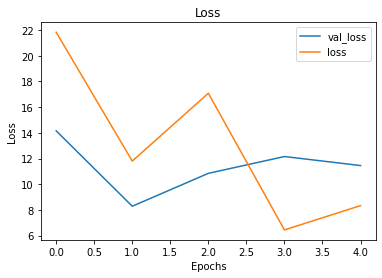

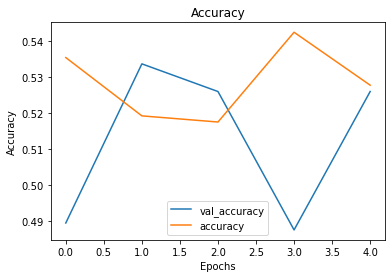

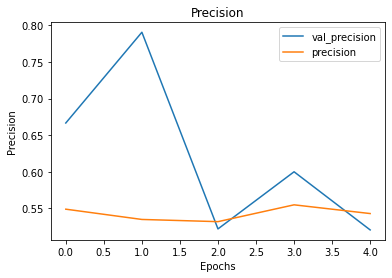

In [8]:
fx.visualize_training_results(base_result)

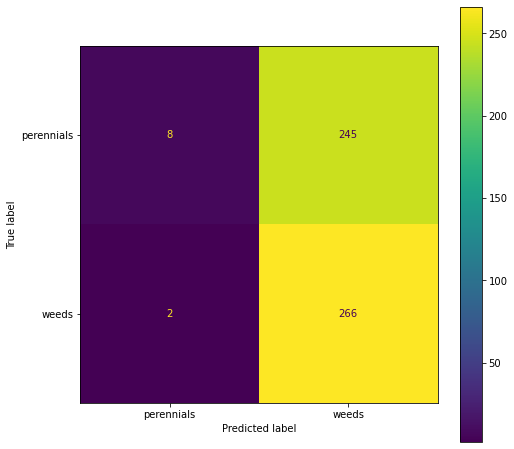

In [9]:
fx.create_confusion_matrix(base_model, val_generator)

In [10]:
fx.get_metrics(base_model, val_generator)

Accuracy: 0.5143953934740882
Precision: 0.5146771037181996


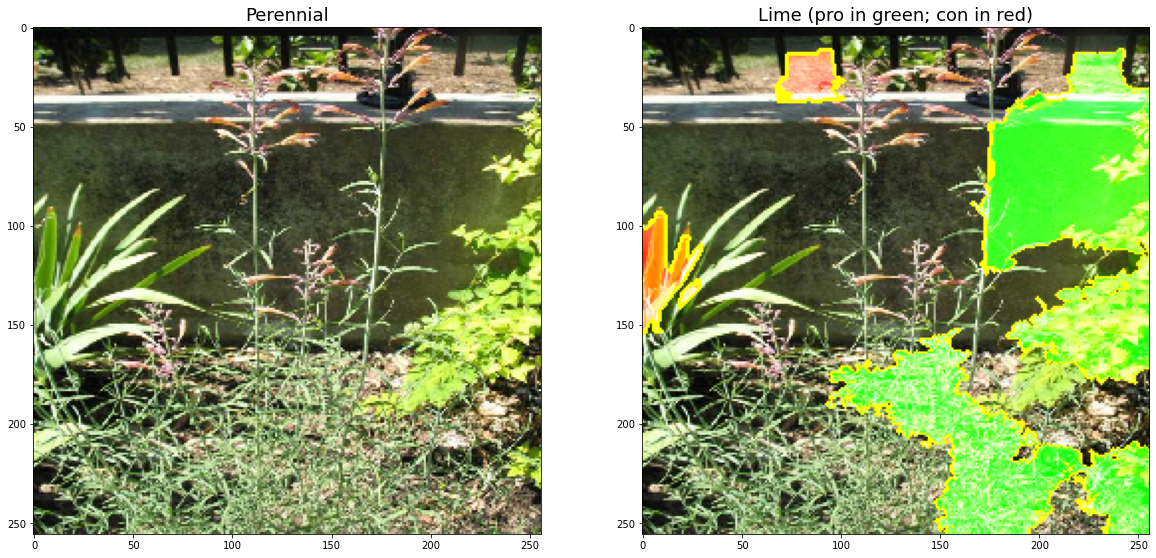

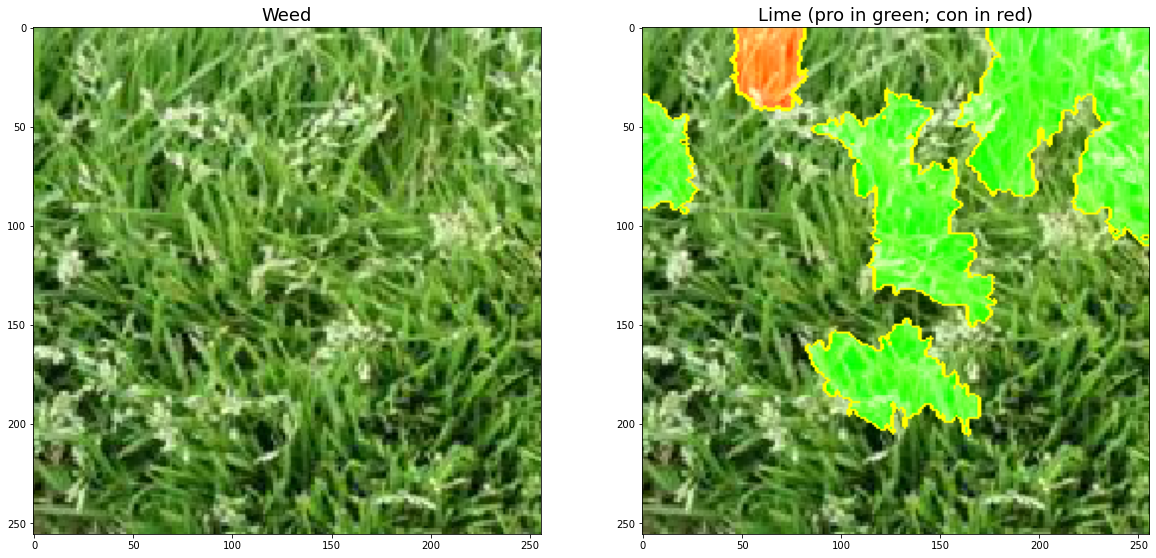

In [30]:
fx.display_lime(base_model, val_generator)

In [31]:
def baseline_cnn(image):
    layers = [
        Input(image.shape),
        Conv2D(32, (3,3), activation = 'relu'),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [32]:
base_cnn = baseline_cnn(train_generator[0][0][0])
base_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2064512)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               264257664 
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 264,258,689
Trainable params: 264,258,689
Non-trainable params: 0
_________________________________________________________________


In [33]:
cnn_result = base_cnn.fit(train_generator, epochs = 10, validation_data=val_generator,
                          class_weight = train_class_weights)

Epoch 1/10
74/74 [==============================] - 129s 2s/step - loss: 8.1355 - accuracy: 0.6588 - precision: 0.6727 - val_loss: 0.7713 - val_accuracy: 0.6276 - val_precision: 0.6201
Epoch 2/10
74/74 [==============================] - 133s 2s/step - loss: 0.5710 - accuracy: 0.7309 - precision: 0.7308 - val_loss: 0.8445 - val_accuracy: 0.6334 - val_precision: 0.6271
Epoch 3/10
74/74 [==============================] - 127s 2s/step - loss: 0.5727 - accuracy: 0.7309 - precision: 0.7320 - val_loss: 0.8119 - val_accuracy: 0.6046 - val_precision: 0.5917
Epoch 4/10
74/74 [==============================] - 125s 2s/step - loss: 0.5403 - accuracy: 0.7407 - precision: 0.7365 - val_loss: 0.9008 - val_accuracy: 0.6718 - val_precision: 0.6887
Epoch 5/10
74/74 [==============================] - 125s 2s/step - loss: 0.5190 - accuracy: 0.7652 - precision: 0.7647 - val_loss: 0.9021 - val_accuracy: 0.6814 - val_precision: 0.7024
Epoch 6/10
74/74 [==============================] - 126s 2s/step - loss: 0.

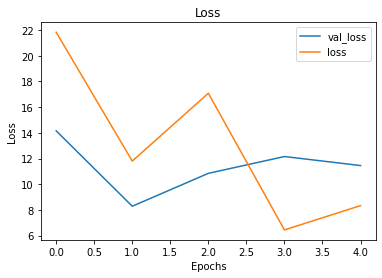

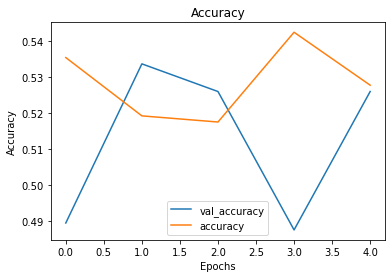

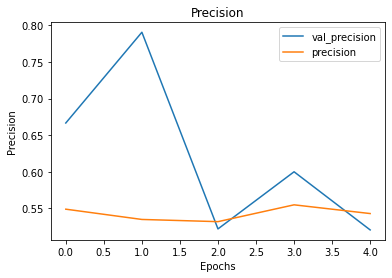

In [34]:
fx.visualize_training_results(base_result)

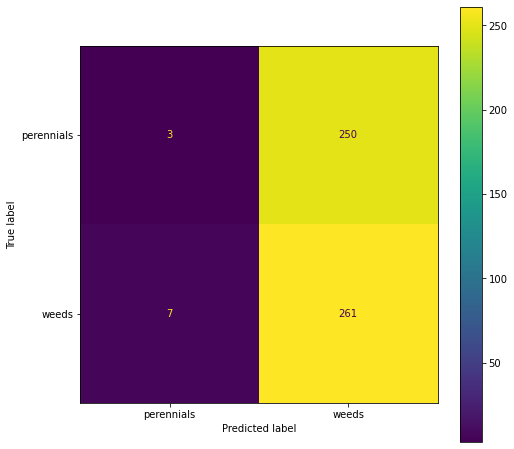

In [35]:
fx.create_confusion_matrix(base_model, val_generator)

In [36]:
fx.get_metrics(base_model, val_generator)

Accuracy: 0.5182341650671785
Precision: 0.5166340508806262


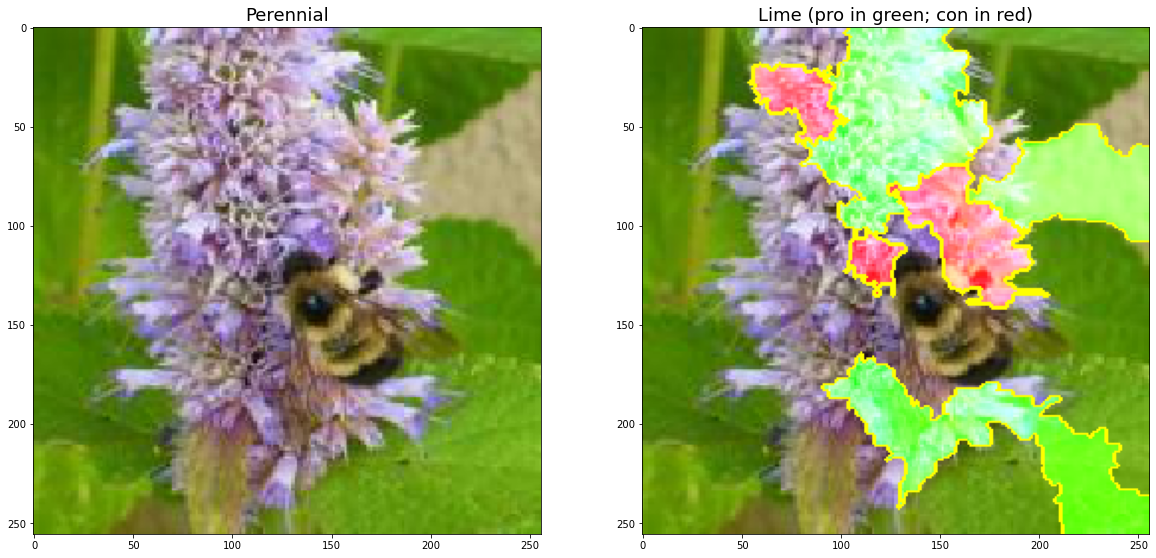

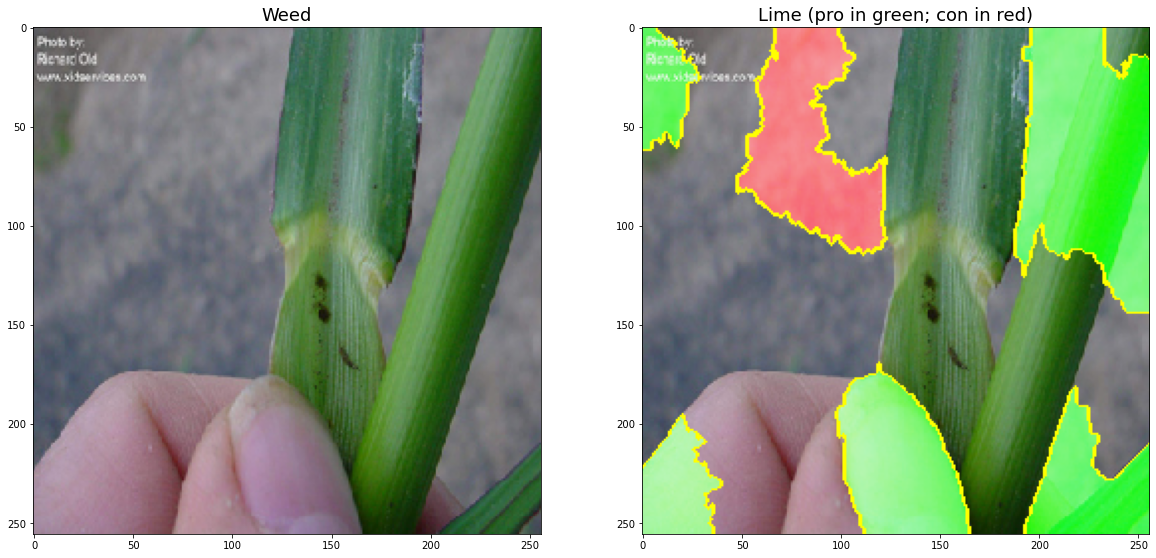

In [37]:
fx.display_lime(base_model, val_generator)